In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dense, Flatten, BatchNormalization, AvgPool2D, Dropout,GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import os
import random
import glob
import shutil
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
%pwd

'E:\\Python HW\\Assignment\\Corona Chest X-ray'

In [3]:
df = pd.read_csv('datasets_562468_1022626_Chest_xray_Corona_Metadata.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


In [5]:
df.isna().any()

Unnamed: 0                False
X_ray_image_name          False
Label                     False
Dataset_type              False
Label_2_Virus_category     True
Label_1_Virus_category     True
dtype: bool

In [6]:
df= df.fillna('Empty')

In [7]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,Empty,Empty
1,1,IM-0127-0001.jpeg,Normal,TRAIN,Empty,Empty
2,2,IM-0125-0001.jpeg,Normal,TRAIN,Empty,Empty
3,3,IM-0122-0001.jpeg,Normal,TRAIN,Empty,Empty
4,4,IM-0119-0001.jpeg,Normal,TRAIN,Empty,Empty
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,Empty,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,Empty,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,Empty,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,Empty,Virus


In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available:', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available: 1


In [9]:
pwd%

'E:\\Python HW\\Assignment\\Corona Chest X-ray'

# Image Comparision

In [10]:
img_normal = plt.imread('Normal_img.jpeg')

In [11]:
img_bacterial = plt.imread('Bacterial_img.jpeg')

In [12]:
img_virus = plt.imread('Virus_img.jpeg')

In [13]:
hist_normal, edges_normal = np.histogram(img_normal, bins = range(150))

In [14]:
hist_bacterial, edges_bacterial = np.histogram(img_bacterial, bins= range(150))


In [15]:
hist_virus, edges_virus = np.histogram(img_virus, bins=range(150))

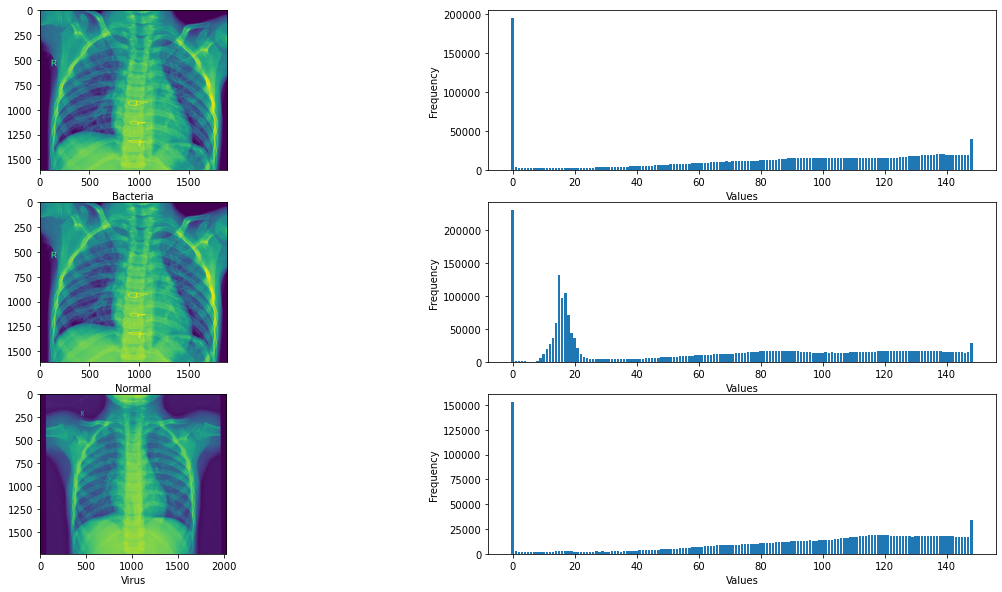

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
ax = ax.ravel()
for i in range(0, 6, 2):
    ax[i+1].set_xlabel('Values')
    ax[i+1].set_ylabel('Frequency')
ax[0].imshow(img_bacterial)
ax[0].set_xlabel('Bacteria')
ax[1].bar(edges_bacterial[:-1], hist_bacterial, width = 0.8)
ax[2].imshow(img_bacterial)
ax[2].set_xlabel('Normal')
ax[3].bar(edges_normal[:-1], hist_normal, width = 0.8)
ax[4].imshow(img_normal)
ax[4].set_xlabel('Virus')
ax[5].bar(edges_virus[:-1], hist_virus, width = 0.8)
plt.show()

# Data Preparation

In [9]:
normal_list = []
virus_list = []
bacteria_list = []
for i in range(len(df['Label'])):
    if df['Label_1_Virus_category'][i] == 'Empty':
        normal_list.append(df['X_ray_image_name'][i])
    elif df['Label_1_Virus_category'][i] == 'Virus':
        virus_list.append(df['X_ray_image_name'][i])
    elif df['Label_1_Virus_category'][i] == 'bacteria':
        bacteria_list.append(df['X_ray_image_name'][i])

In [8]:
os.chdir('data/Chest_x-ray')

In [9]:
if os.path.isdir('train/Normal') is False:
    os.makedirs('train/Normal')
    os.makedirs('train/Virus')
    os.makedirs('train/Bacteria')
    os.makedirs('valid/Normal')
    os.makedirs('valid/Virus')
    os.makedirs('valid/Bacteria')
    os.makedirs('test/Normal')
    os.makedirs('test/Virus')
    os.makedirs('test/Bacteria')
    
    for i in random.sample(normal_list[:500], 500):
        shutil.move(src=i, dst='train/Normal')
    for i in random.sample(virus_list[:500], 500):
        shutil.move(src=i, dst='train/Virus')
    for i in random.sample(bacteria_list[:500], 500):
        shutil.move(src=i, dst='train/Bacteria')
    for i in random.sample(normal_list[500:1000], 100):
        shutil.move(src=i, dst='valid/Normal')
    for i in random.sample(virus_list[500:1000], 100):
        shutil.move(src=i, dst='valid/Virus')
    for i in random.sample(bacteria_list[500:1000], 100):
        shutil.move(src=i, dst='valid/Bacteria')
    for i in random.sample(normal_list[1000:], 50):
        shutil.move(src=i, dst='test/Normal')
    for i in random.sample(virus_list[1000:], 50):
        shutil.move(src=i, dst='test/Virus')
    for i in random.sample(bacteria_list[1000:], 50):
        shutil.move(src=i, dst='test/Bacteria')

os.chdir('../../')

In [10]:
print(len(normal_list))
print(len(virus_list))
print(len(bacteria_list))

1576
1555
2777


In [11]:
train_path = 'data/Chest_x-ray/train'
valid_path = 'data/Chest_x-ray/valid'
test_path = 'data/Chest_x-ray/test'

In [12]:
train_batches = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)\
    .flow_from_directory(directory=train_path, target_size=(150, 150), classes=['Bacteria', 'Normal', 'Virus'], batch_size=8)
valid_batches = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)\
    .flow_from_directory(directory=valid_path, target_size=(150, 150), classes=['Bacteria', 'Normal', 'Virus'],batch_size=8)
test_batches = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)\
    .flow_from_directory(directory=test_path, target_size=(150, 150), classes=['Bacteria', 'Normal', 'Virus'],batch_size=8, shuffle=False)


Found 1500 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# Data Visualization

In [13]:
imgs, labels = next(train_batches)

In [14]:
def plot_Images(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img,cmap=plt.cm.Blues)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

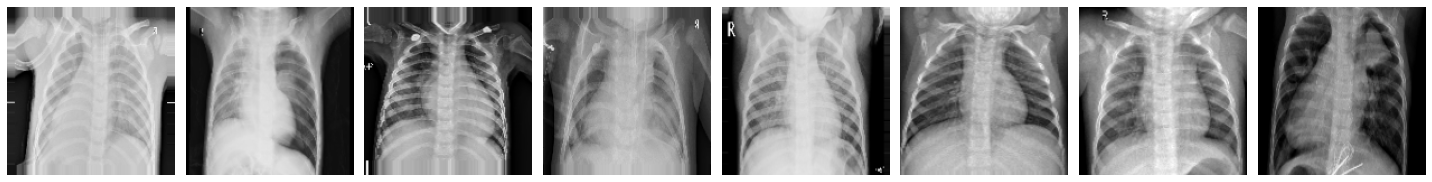

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [15]:
plot_Images(imgs)
print(labels)

Text(0.5, 0, '[1. 0. 0.]')

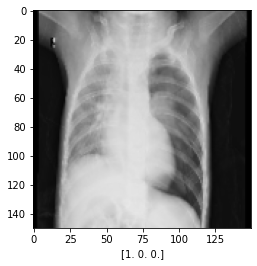

In [16]:
plt.imshow(imgs[1])
plt.xlabel(labels[1])

# Build and Train CNN Model

In [17]:
base_model = tf.keras.applications.VGG16(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [19]:
base_model.trainable = False

In [20]:
model1 = Sequential()

In [21]:
model1.add(base_model)
model1.add(Flatten())
model1.add(Dense(32))
model1.add(Dropout(0.5))
model1.add(Dense(units=3, activation = 'sigmoid'))

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 14,976,963
Trainable params: 262,275
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model1.compile(optimizer=Adam(learning_rate = 0.001), loss= 'binary_crossentropy', metrics=['accuracy'])

In [24]:
history = model1.fit(x=train_batches, validation_data = valid_batches, epochs=20, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 188 steps, validate for 38 steps
Epoch 1/20
188/188 - 35s - loss: 0.6186 - accuracy: 0.7436 - val_loss: 0.5744 - val_accuracy: 0.7411
Epoch 2/20
188/188 - 31s - loss: 0.4673 - accuracy: 0.7907 - val_loss: 0.5207 - val_accuracy: 0.7589
Epoch 3/20
188/188 - 31s - loss: 0.4528 - accuracy: 0.8011 - val_loss: 0.4619 - val_accuracy: 0.8000
Epoch 4/20
188/188 - 31s - loss: 0.4108 - accuracy: 0.8256 - val_loss: 0.4564 - val_accuracy: 0.8056
Epoch 5/20
188/188 - 31s - loss: 0.3740 - accuracy: 0.8302 - val_loss: 0.4316 - val_accuracy: 0.8178
Epoch 6/20
188/188 - 31s - loss: 0.3448 - accuracy: 0.8371 - val_loss: 0.4380 - val_accuracy: 0.8022
Epoch 7/20
188/188 - 31s - loss: 0.3534 - accuracy: 0.8376 - val_loss: 0.4603 - val_accuracy: 0.7867
Epoch 8/20
188/188 - 31s - loss: 0.3502 - accuracy: 0.8436 - val_loss: 0.4339 - val_accuracy: 0.8122
Epoch 9/20
188/188 - 31s - loss: 0.3218 - accuracy: 0.8564 - val_loss: 0.4381 - val_accuracy: 0.807

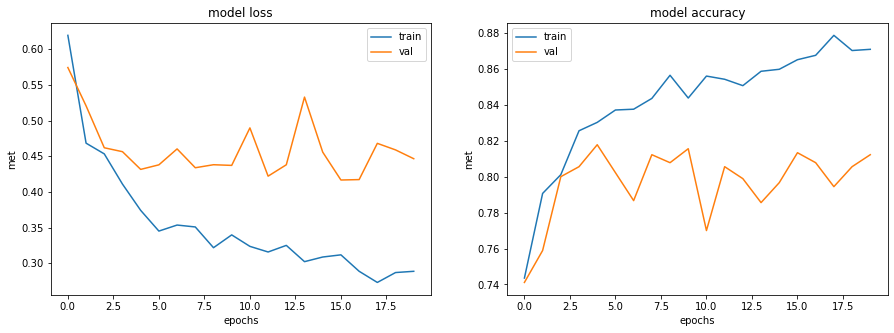

In [25]:
fig , ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()
for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel('met')
    ax[i].legend(['train', 'val'])

In [26]:
test_loss, test_acc = model1.evaluate(x= test_batches, verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  ...
    to  
  ['...']
19/19 - 9s - loss: 0.5134 - accuracy: 0.8000
Test Loss: 0.5134420253728565
Test Accuracy: 0.79999995


# Test Data Visualization

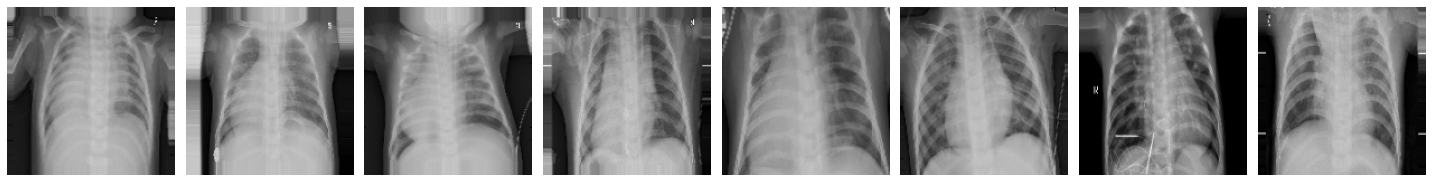

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [27]:
test_imgs, test_labels = next(test_batches)
plot_Images(test_imgs)
print(test_labels)

# Predict

In [28]:
predictions = model1.predict(x=test_batches, verbose=2)

19/19 - 8s


In [29]:
np.round(predictions)

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 1.],
       [0., 1., 0.],
       [0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0

# Plot Confusion Matrix

In [30]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, titles='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(titles)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm= cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion Matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh= cm.max()/2

Confusion matrix, without normalization
[[30  3 17]
 [ 5 35 10]
 [13  2 35]]


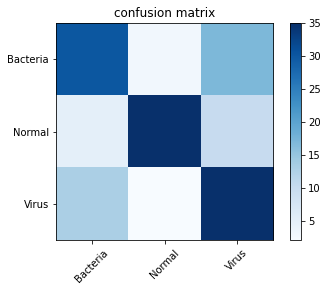

In [32]:
cm_plot_labels = ['Bacteria', 'Normal', 'Virus']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, titles='confusion matrix')
